# Example Notebook to analyse session_data.csv from models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D



In [2]:
# Load the data from the CSV file
file_path = '/home/luca/carla/source/results/MH-0/town7_opt4km_inj-0/session_data.csv'
data = pd.read_csv(file_path)

In [3]:
# Identify rows where IMU data columns are all zeros
imu_data_cols = ['AccelX', 'AccelY', 'AccelZ', 'AngularVelX', 'AngularVelY', 'AngularVelZ']
data[imu_data_cols] = data[imu_data_cols].replace(0, np.nan)

# Interpolate the IMU data columns
data[imu_data_cols] = data[imu_data_cols].interpolate(method='linear')

# Add Meters
# Calculate distance in meters using the X and Y coordinates
# Shift the X and Y columns to calculate differences
data['X_Shift'] = data['X'].shift()
data['Y_Shift'] = data['Y'].shift()

# Calculate the Euclidean distance between consecutive points
data['Distance'] = np.sqrt((data['X'] - data['X_Shift'])**2 + (data['Y'] - data['Y_Shift'])**2)

# Cumulatively sum the distances to get a "meters" column
data['Meters'] = data['Distance'].cumsum()

# Drop temporary columns used for calculation
data.drop(['X_Shift', 'Y_Shift', 'Distance'], axis=1, inplace=True)

# Display the updated data structure
data[['Timestamp', 'X', 'Y', 'Meters']].head()

print(data['Meters'].max())

3992.870811983439


/home/luca/carla/venv_training/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


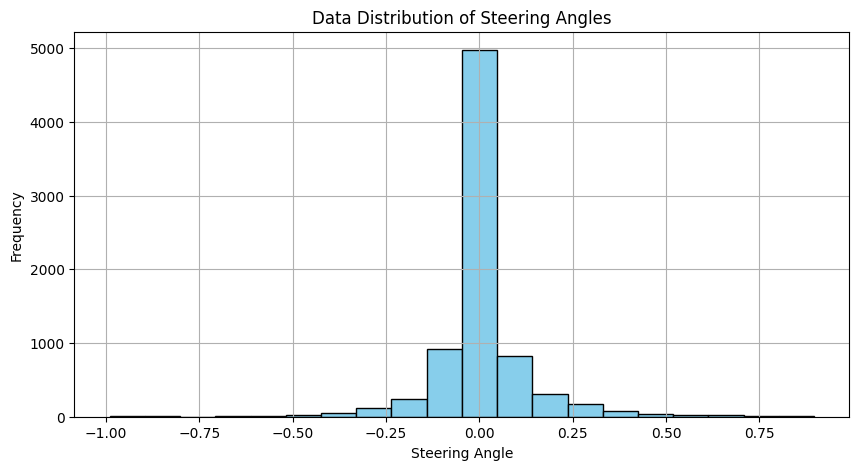

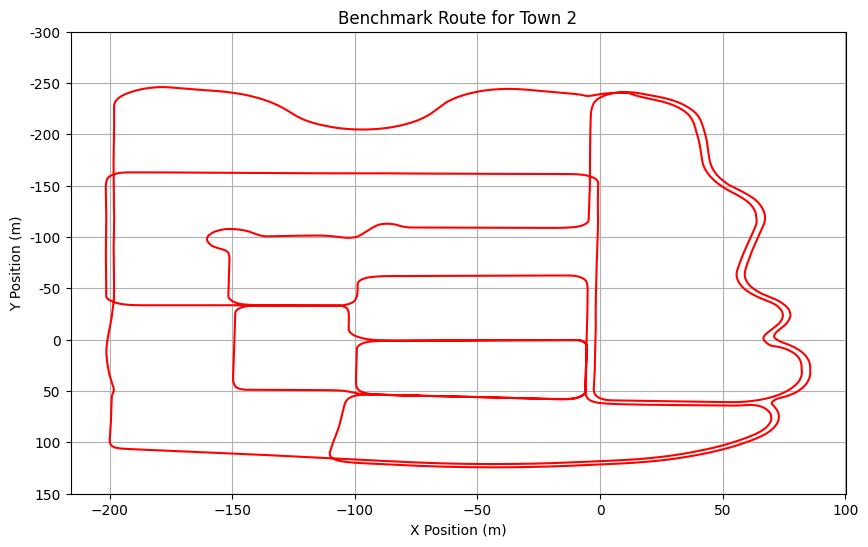

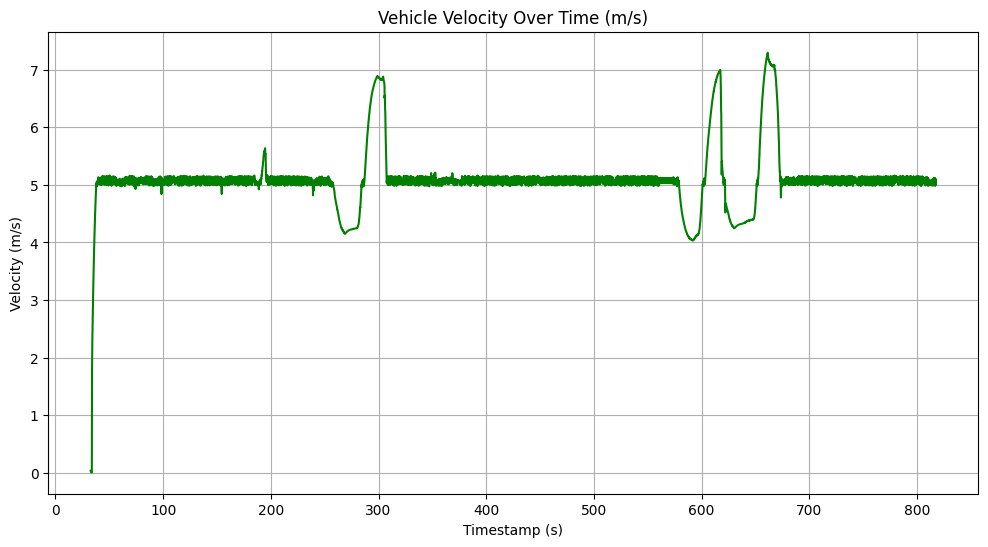

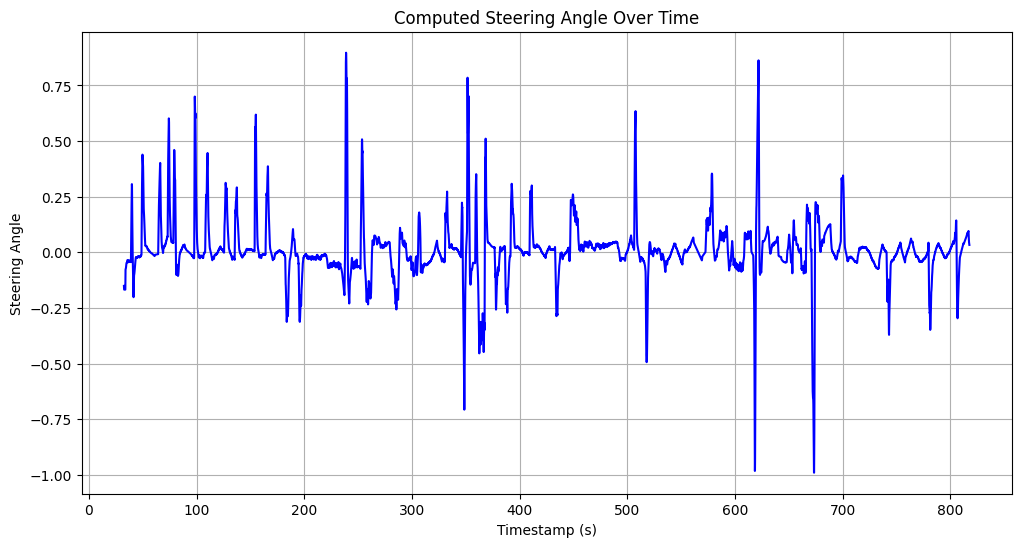

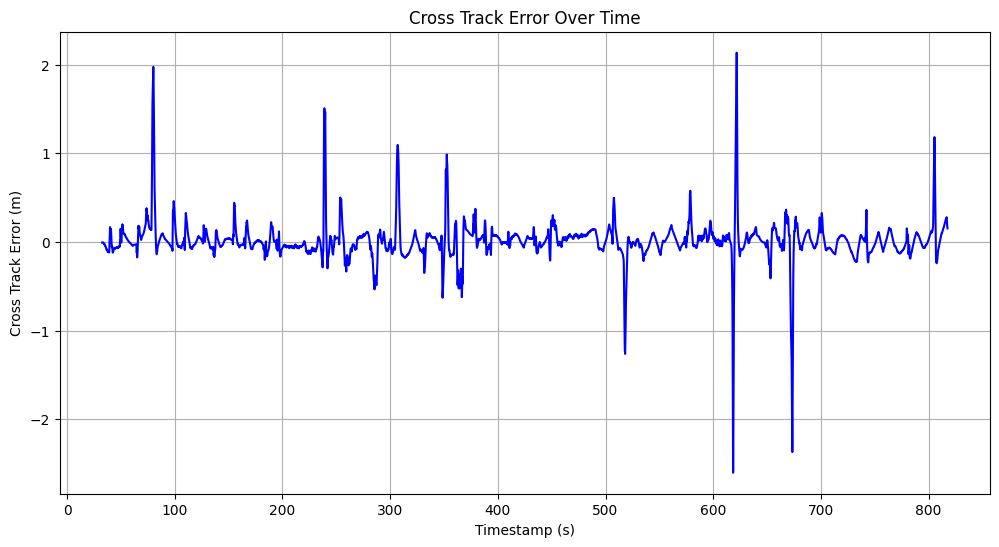

Min CTE: -2.6049956078780503
Max CTE: 2.13541205713609
Mean CTE: 0.014087243979414805
Abs Mean CTE: 0.11493902170557033


In [4]:
# Calculate velocity from X, Y positions
data['Velocity'] = np.sqrt(data['VelX']**2 + data['VelY']**2 + data['VelZ'])

# Plot data distribution of steering angles
plt.figure(figsize=(10, 5))
plt.hist(data['StanleySteeringAngle'], bins=20, color='skyblue', edgecolor='black')
plt.title('Data Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2D diagram with x/y positions of the vehicle
plt.figure(figsize=(10, 6))
plt.plot(data['X'],-data['Y'], color='red')
plt.title('Benchmark Route for Town 2')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
x_ticks, x_labels = plt.yticks()
plt.yticks(x_ticks, [f'{-int(tick)}' for tick in x_ticks])
plt.savefig("town1_route.png")
#plt.axis('equal')
plt.show()

# Diagram with vehicle velocity over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['Velocity'], color='green')
plt.title('Vehicle Velocity Over Time (m/s)')
plt.xlabel('Timestamp (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.show()

# Diagram with the steering angle over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['StanleySteeringAngle'], color='blue')
plt.title('Computed Steering Angle Over Time')
plt.xlabel('Timestamp (s)')
plt.ylabel('Steering Angle')
plt.grid(True)
plt.show()

# Diagram with the steering angle over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['CrossTrackError'], color='blue')
plt.title('Cross Track Error Over Time')
plt.xlabel('Timestamp (s)')
plt.ylabel('Cross Track Error (m)')
plt.grid(True)
plt.show()

# Calculate min, max, mean, and average CTE
min_cte = data['CrossTrackError'].min()
max_cte = data['CrossTrackError'].max()
mean_cte = data['CrossTrackError'].mean()
abs_mean_cte = data['CrossTrackError'].abs().mean()

print("Min CTE:", min_cte)
print("Max CTE:", max_cte)
print("Mean CTE:", mean_cte)
print("Abs Mean CTE:", abs_mean_cte)






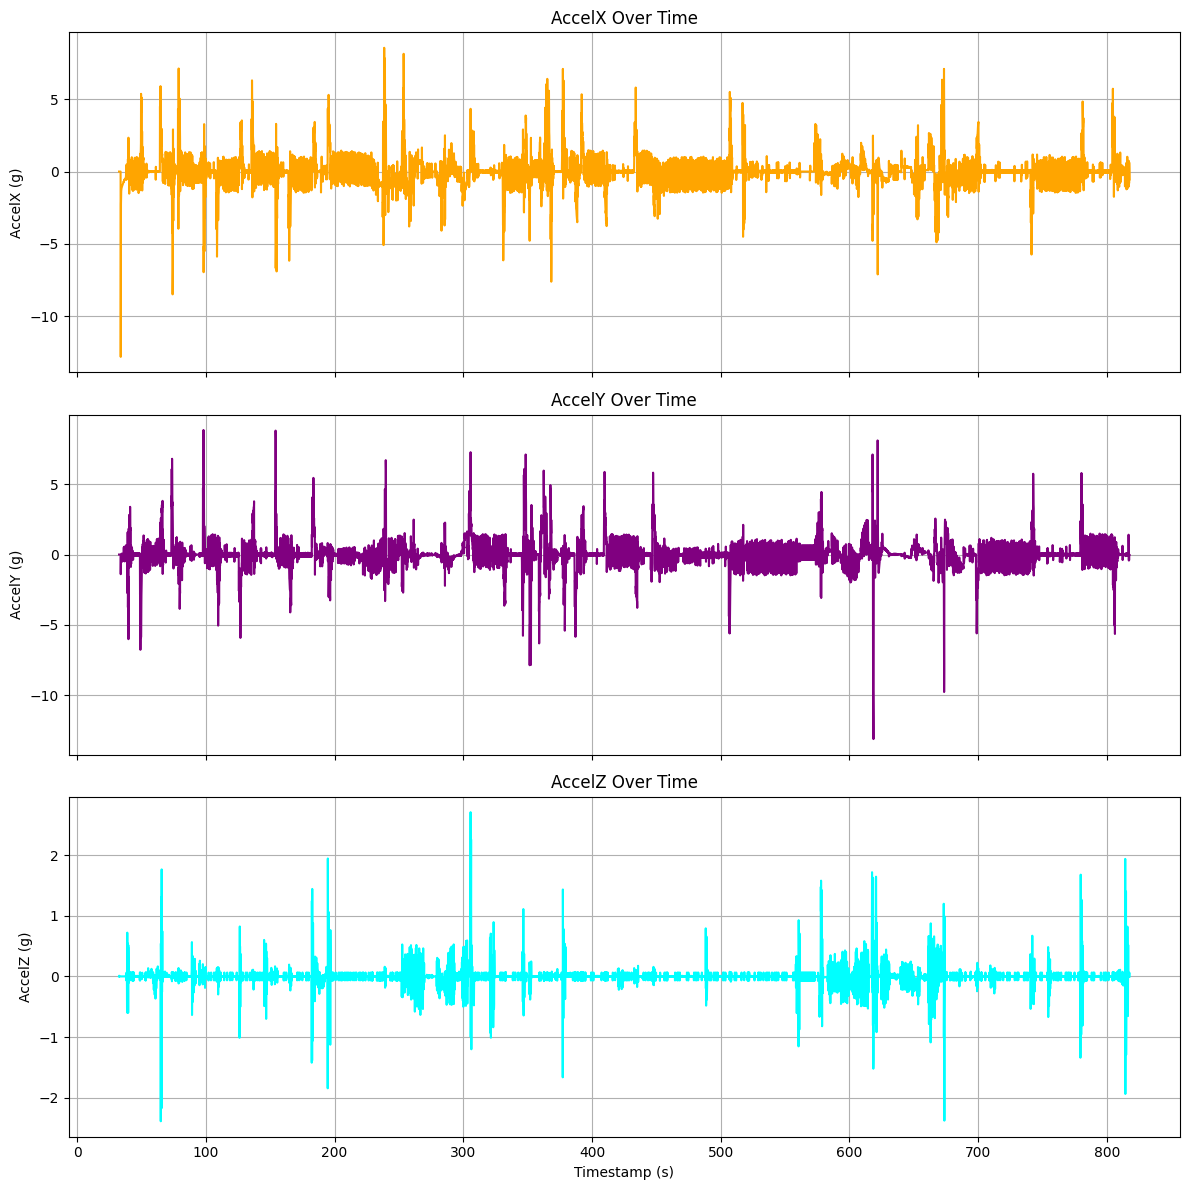

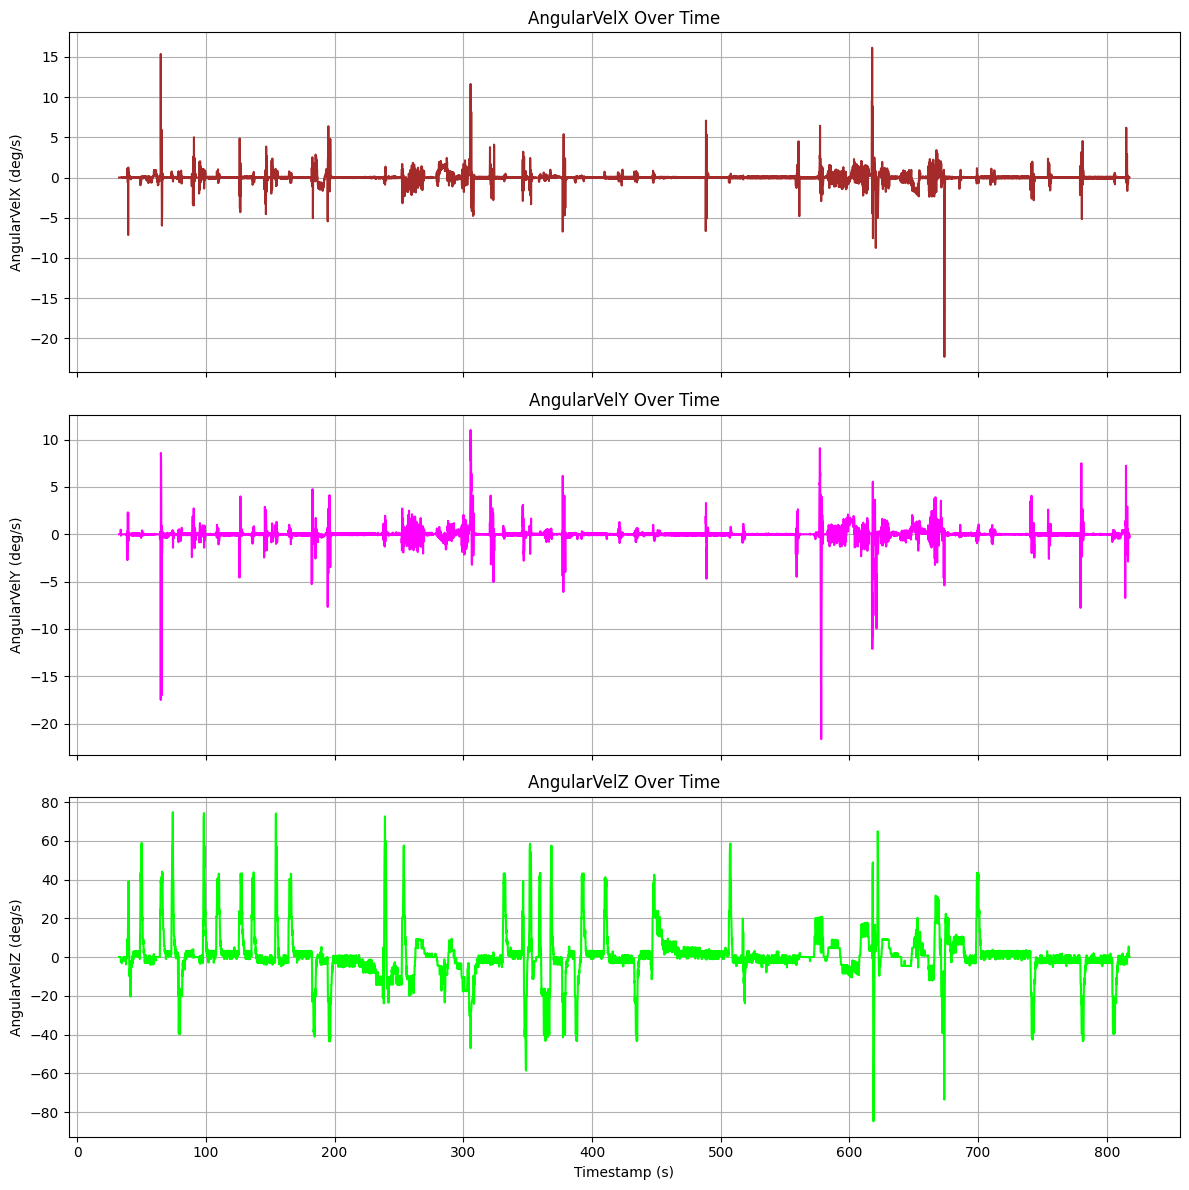

In [5]:
# IMU data plots: AccelX, AccelY, AccelZ
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
imu_data_cols_to_plot = ['AccelX', 'AccelY', 'AccelZ']
colors = ['orange', 'purple', 'cyan']

for i, col in enumerate(imu_data_cols_to_plot):
    axs[i].plot(data['Timestamp'], data[col], color=colors[i])
    axs[i].set_title(f'{col} Over Time')
    axs[i].set_ylabel(f'{col} (g)')
    axs[i].grid(True)

axs[-1].set_xlabel('Timestamp (s)')
plt.tight_layout()
plt.show()

# IMU data plots: GyroX, GyroY, GyroZ
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
gyro_data_cols = ['AngularVelX', 'AngularVelY', 'AngularVelZ']
gyro_colors = ['brown', 'magenta', 'lime']

for i, col in enumerate(gyro_data_cols):
    axs[i].plot(data['Timestamp'], data[col], color=gyro_colors[i])
    axs[i].set_title(f'{col} Over Time')
    axs[i].set_ylabel(f'{col} (deg/s)')
    axs[i].grid(True)

axs[-1].set_xlabel('Timestamp (s)')
plt.tight_layout()
plt.show()



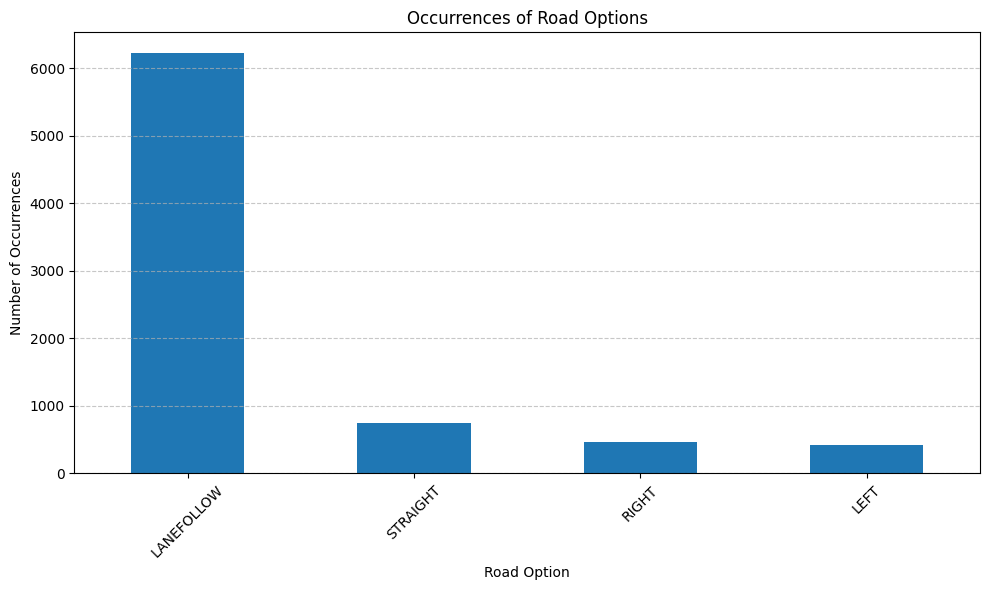

In [6]:
# Count occurrences of each unique value in the 'current_road_option' column
road_option_counts = data['CurrentRoadOption'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
road_option_counts.plot(kind='bar', rot=45)
plt.title('Occurrences of Road Options')
plt.xlabel('Road Option')
plt.ylabel('Number of Occurrences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# General Statistics

In [7]:
# General statistics and metrics calculation
total_distance = data['Meters'].iloc[-1]  # Total distance driven (in meters)
total_time = (data['Timestamp'].iloc[-1] - data['Timestamp'].iloc[0]) / 3600  # Total time driven (in hours)

# Count interventions (when steering mode switches to 'Stanley')
intervention_changes = (data['ExecutedBy'] != data['ExecutedBy'].shift()).sum()
stanley_interventions = data['ExecutedBy'].value_counts().get('Stanley', 0)

# Metrics
interventions_per_km = stanley_interventions / (total_distance / 1000)  # Interventions per km
intervention_time_per_hour = (data[data['ExecutedBy'] == 'Stanley'].shape[0] / data.shape[0]) * total_time  # Time in Stanley mode per hour

# Analysis on interventions at specific scenarios
intervention_at_junctions = data[(data['ExecutedBy'] == 'Stanley') & (data['IsCarAtJunction'])].shape[0]
intervention_during_left_turns = data[(data['ExecutedBy'] == 'Stanley') & (data['CurrentRoadOption'] == 'LEFT')].shape[0]
intervention_during_right_turns = data[(data['ExecutedBy'] == 'Stanley') & (data['CurrentRoadOption'] == 'RIGHT')].shape[0]

# Display general statistics
metrics = {
    "Total Distance Driven (km)": total_distance / 1000,
    "Total Driving Time (hours)": total_time,
    "Total Interventions (Stanley)": stanley_interventions,
    "Interventions per km": interventions_per_km,
    "Intervention Time per Hour (Stanley)": intervention_time_per_hour,
    "Interventions at Junctions": intervention_at_junctions,
    "Interventions During Left Turns": intervention_during_left_turns,
    "Interventions During Right Turns": intervention_during_right_turns,
}

metrics


# Define intervention as starting when 'ExecutedBy' changes to 'Stanley' and ending when it changes back to 'PilotNet'
data['InterventionFlag'] = ((data['ExecutedBy'].shift() == 'PilotNet') & (data['ExecutedBy'] == 'Stanley')) | \
                           ((data['ExecutedBy'].shift() == 'Stanley') & (data['ExecutedBy'] == 'PilotNet'))

# Assign an ID to each intervention based on the InterventionFlag
data['InterventionID'] = data['InterventionFlag'].cumsum()

# Filter only interventions (Stanley sections)
interventions = data[data['ExecutedBy'] == 'Stanley']

# Analyze each intervention
intervention_summary = interventions.groupby('InterventionID').apply(
    lambda group: pd.Series({
        'StartMeter': group['Meters'].iloc[0],
        'EndMeter': group['Meters'].iloc[-1],
        'DistanceCovered': group['Meters'].iloc[-1] - group['Meters'].iloc[0],
        'StartTime': group['Timestamp'].iloc[0],
        'EndTime': group['Timestamp'].iloc[-1],
        'Duration': group['Timestamp'].iloc[-1] - group['Timestamp'].iloc[0],
        'MajorityRoadOption': group['CurrentRoadOption'].iloc[0] if not group['CurrentRoadOption'].empty else None,
        'AtJunction': group['IsCarAtJunction'].iloc[0]   # Majority of timesteps at junction
    })
).reset_index()

# Summarize overall statistics
total_interventions = intervention_summary.shape[0]
interventions_per_km = total_interventions / (total_distance / 1000)
intervention_time_per_hour = intervention_summary['Duration'].sum() / total_time

# Group by MajorityRoadOption for additional insights
road_option_intervention_counts = intervention_summary['MajorityRoadOption'].value_counts()

# Display results
intervention_metrics = {
    "Total Interventions": total_interventions,
    "Interventions per km": interventions_per_km,
    "Intervention Time per Hour": intervention_time_per_hour,
    "Interventions by Road Option": road_option_intervention_counts.to_dict(),
    "Interventions at Junctions": intervention_summary['AtJunction'].sum()
}

intervention_metrics


/tmp/ipykernel_66348/3795930078.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  intervention_summary = interventions.groupby('InterventionID').apply(


{'Total Interventions': 4,
 'Interventions per km': 1.0017854792584735,
 'Intervention Time per Hour': 26.595338173481217,
 'Interventions by Road Option': {'STRAIGHT': 2, 'LANEFOLLOW': 1, 'LEFT': 1},
 'Interventions at Junctions': 3}

In [8]:
# Add a column to mark failure scenarios
data['Failure'] = data['ExecutedBy'] == 'Stanley'

# Aggregate the data for analysis
failure_data = data[data['Failure']]
success_data = data[~data['Failure']]

# Print the counts of failures and successes
len_failures = len(failure_data)
len_successes = len(success_data)

# CTE PLot with Indicated Road Options

/tmp/ipykernel_66348/3608329237.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(data['CurrentRoadOption'].unique()))


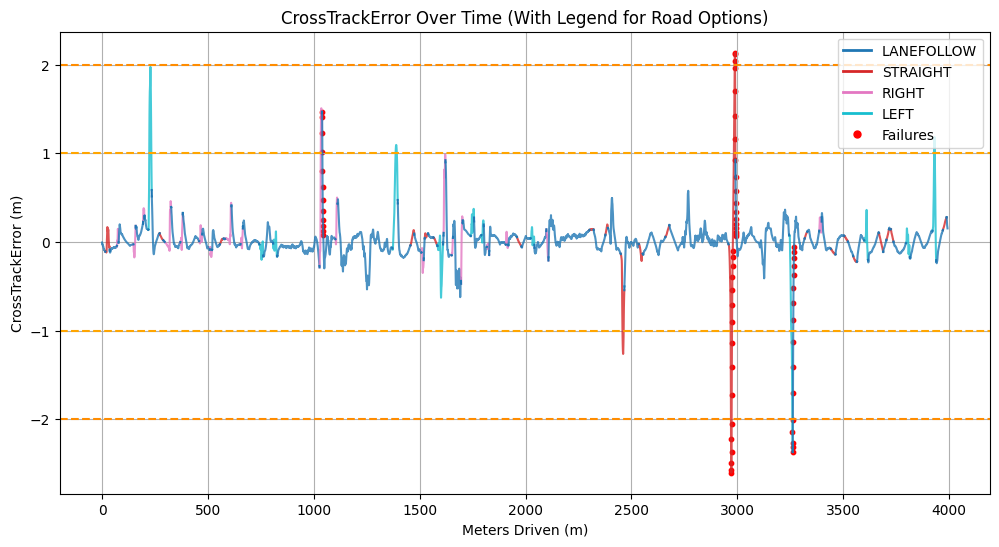

In [9]:
unique_road_options = data["CurrentRoadOption"].unique()
data['Segment'] = (data['CurrentRoadOption'] != data['CurrentRoadOption'].shift()).cumsum()


plt.figure(figsize=(12, 6))
color_map = plt.cm.get_cmap('tab10', len(data['CurrentRoadOption'].unique()))

# Plot coherent sequences with connections between them
previous_end = None
for segment_id, segment_data in data.groupby('Segment'):
    road_option = segment_data['CurrentRoadOption'].iloc[0]
    color_idx = list(unique_road_options).index(road_option)  # Get color index based on road option
    
    # Plot the current segment
    plt.plot(segment_data['Meters'], segment_data['CrossTrackError'],
             color=color_map(color_idx), alpha=0.8)
    
    # Connect to the previous segment, if applicable
    if previous_end is not None:
        plt.plot([previous_end['Meters'], segment_data.iloc[0]['Meters']],
                 [previous_end['CrossTrackError'], segment_data.iloc[0]['CrossTrackError']],
                 color=color_map(0), alpha=1)
    
    # Update the previous end point
    previous_end = segment_data.iloc[-1]

# Add failure points for context
failure_data = data[data['ExecutedBy'] == 'Stanley']
plt.scatter(failure_data['Meters'], failure_data['CrossTrackError'],
            color='red', label='Failures', s=10, alpha=1)

# Add threshold lines
plt.axhline(1, color='orange', linestyle='--', label='Threshold (1m)')
plt.axhline(-1, color='orange', linestyle='--')
plt.axhline(2, color='darkorange', linestyle='--', label='Threshold (2m)')
plt.axhline(-2, color='darkorange', linestyle='--')

# Create a custom legend
legend_elements = [
    Line2D([0], [0], color=color_map(idx), lw=2, label=road_option)
    for idx, road_option in enumerate(unique_road_options)
]
legend_elements.append(Line2D([0], [0], color='red', marker='o', linestyle='None', label='Failures', markersize=5))
#legend_elements.append(Line2D([0], [0], color='gray', linestyle='--', label='Segment Connections'))
#legend_elements.append(Line2D([0], [0], color='orange', linestyle='--', label='Threshold (1m)'))

plt.legend(handles=legend_elements, loc='upper right')

# Finalize plot
plt.title('CrossTrackError Over Time (With Legend for Road Options)')
plt.xlabel('Meters Driven (m)')
plt.ylabel('CrossTrackError (m)')
plt.grid()
plt.show()


# Combined CTE Plot with Road Types

['LANEFOLLOW' 'LEFT' 'STRAIGHT' 'RIGHT']


/tmp/ipykernel_66348/59300014.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Dark2', len(unique_road_options))


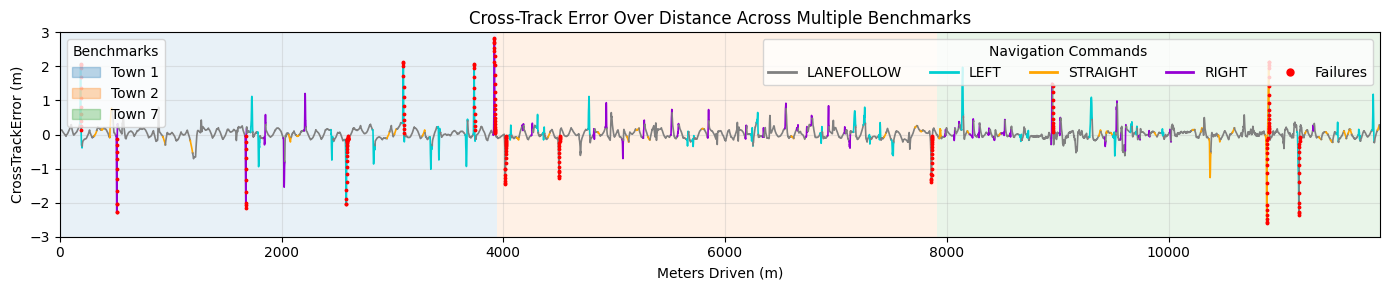

Total distance covered: 11906.98 meters


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.patches as patches


# Define file paths and corresponding benchmark information
file_paths = [
    '/home/luca/carla/source/results/MH-0/town1_opt4km_inj-0/session_data.csv',
    '/home/luca/carla/source/results/MH-0/town2_opt4km_inj-0/session_data.csv',
    '/home/luca/carla/source/results/MH-0/town7_opt4km_inj-0/session_data.csv'
]


benchmark_names = ['Town 1', 'Town 2', 'Town 7']
benchmark_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Function to process a single CSV file
def process_csv(file_path):
    data = pd.read_csv(file_path)
    
    # Identify rows where IMU data columns are all zeros
    imu_data_cols = ['AccelX', 'AccelY', 'AccelZ', 'AngularVelX', 'AngularVelY', 'AngularVelZ']
    data[imu_data_cols] = data[imu_data_cols].replace(0, np.nan)
    
    # Interpolate the IMU data columns
    data[imu_data_cols] = data[imu_data_cols].interpolate(method='linear')
    
    # Calculate distance in meters using the X and Y coordinates
    data['X_Shift'] = data['X'].shift()
    data['Y_Shift'] = data['Y'].shift()
    data['Distance'] = np.sqrt((data['X'] - data['X_Shift'])**2 + (data['Y'] - data['Y_Shift'])**2)
    data['Meters'] = data['Distance'].cumsum()
    
    # Drop temporary columns used for calculation
    data.drop(['X_Shift', 'Y_Shift', 'Distance'], axis=1, inplace=True)
    
    return data

# Load and process all datasets
all_data = []
current_offset = 0

for i, file_path in enumerate(file_paths):
    # Process the CSV
    data = process_csv(file_path)
    
    # Add benchmark information
    data['Benchmark'] = benchmark_names[i]
    data['BenchmarkID'] = i
    
    # Adjust meters if not the first benchmark
    if i > 0:
        data['Meters'] = data['Meters'] + current_offset
    
    # Update offset for the next benchmark
    current_offset = data['Meters'].max()
    
    # Add to our list
    all_data.append(data)

# Combine all datasets
combined_data = pd.concat(all_data, ignore_index=True)

# Identify road option segments (reset at each benchmark transition)
combined_data['BenchmarkTransition'] = (combined_data['BenchmarkID'] != combined_data['BenchmarkID'].shift(fill_value=-1)).astype(int)
combined_data['RoadOptionChange'] = (combined_data['CurrentRoadOption'] != combined_data['CurrentRoadOption'].shift(fill_value='NONE')).astype(int)
combined_data['Segment'] = (combined_data['BenchmarkTransition'] | combined_data['RoadOptionChange']).cumsum()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 3))

# Plot background colors for each benchmark
for i, benchmark in enumerate(benchmark_names):
    benchmark_data = combined_data[combined_data['BenchmarkID'] == i]
    if len(benchmark_data) > 0:
        min_meters = benchmark_data['Meters'].min()
        max_meters = benchmark_data['Meters'].max()
        # Add a colored rectangle for this benchmark's section
        rect = patches.Rectangle((min_meters, -5), max_meters - min_meters, 10, 
                                 linewidth=0, alpha=0.1, color=benchmark_colors[i])
        ax.add_patch(rect)

# Get unique road options across all data
unique_road_options = combined_data["CurrentRoadOption"].unique()
print(unique_road_options)
color_map = plt.cm.get_cmap('Dark2', len(unique_road_options))
color_map = ["gray","darkturquoise", "orange", "darkviolet"]

# Plot coherent sequences with connections between them
previous_end = None
for segment_id, segment_data in combined_data.groupby('Segment'):
    road_option = segment_data['CurrentRoadOption'].iloc[0]
    color_idx = list(unique_road_options).index(road_option)  # Get color index based on road option
    
    # Plot the current segment
    plt.plot(segment_data['Meters'], segment_data['CrossTrackError'],
             color=color_map[color_idx], alpha=1, linewidth=1.2)
    
    # Connect to the previous segment, if applicable
    if previous_end is not None and previous_end['BenchmarkID'] == segment_data.iloc[0]['BenchmarkID']:
        # Only connect segments within the same benchmark
        plt.plot([previous_end['Meters'], segment_data.iloc[0]['Meters']],
                 [previous_end['CrossTrackError'], segment_data.iloc[0]['CrossTrackError']],
                 color=color_map[0], alpha=1, zorder=1, linewidth=1.2)
    
    # Update the previous end point
    previous_end = segment_data.iloc[-1]

# Add failure points for context
failure_data = combined_data[combined_data['ExecutedBy'] == 'Stanley']
plt.scatter(failure_data['Meters'], failure_data['CrossTrackError'],
            color='red', label='Failures', s=3, alpha=1,zorder=2)

# Add threshold lines
#plt.axhline(1, color='orange', linestyle='--', label='Threshold (1m)')
#plt.axhline(-1, color='orange', linestyle='--')
#plt.axhline(2, color='darkorange', linestyle='--', label='Threshold (2m)')
#plt.axhline(-2, color='darkorange', linestyle='--')

# Create legend for road options and other elements
road_legend_elements = [
    Line2D([0], [0], color=color_map[idx], lw=2, label=road_option)
    for idx, road_option in enumerate(unique_road_options)
]
road_legend_elements.append(Line2D([0], [0], color='red', marker='o', linestyle='None', label='Failures', markersize=5))
#road_legend_elements.append(Line2D([0], [0], color='orange', linestyle='--', label='Threshold (1m)'))
#road_legend_elements.append(Line2D([0], [0], color='darkorange', linestyle='--', label='Threshold (2m)'))

# Create legend for benchmarks
benchmark_legend_elements = [
    patches.Patch(color=benchmark_colors[i], alpha=0.3, label=benchmark_names[i])
    for i in range(len(benchmark_names))
]

# Add both legends
# First legend for road options
first_legend = plt.legend(handles=road_legend_elements, loc='upper right', title='Navigation Commands',ncol=7)
ax.add_artist(first_legend)

# Second legend for benchmarks
plt.legend(handles=benchmark_legend_elements, loc='upper left', title='Benchmarks')

# Finalize plot
plt.title('Cross-Track Error Over Distance Across Multiple Benchmarks') 
plt.xlabel('Meters Driven (m)')
plt.ylabel('CrossTrackError (m)')
plt.grid(True, alpha=0.3)
plt.xlim(0, combined_data['Meters'].max() + 0)  # Add some padding to the x-axis
plt.ylim(-3, 3)  # Reasonable y-axis limits for CrossTrackError
plt.tight_layout()
plt.show()

# Print total distance covered
print(f"Total distance covered: {combined_data['Meters'].max():.2f} meters")